In [2]:
import numpy as np
import pandas as pd

from importlib import reload

import synthetic.render.generator as gen

import matplotlib.pyplot as plt
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl

# create raw canvas

In [3]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'
catalog = fio.read(catalog_path)
catalog_cluster = catalog[catalog['LOC'] == 1]
catalog_field = catalog[catalog['LOC'] == 0]

In [4]:
df = render.DrawField(5000, catalog_cluster, band="z")

In [5]:
df.prepare()
df.make_infodicts()
df.multi_render(10)
df.collate_stamps()

starting xshear calculations in 10 processes


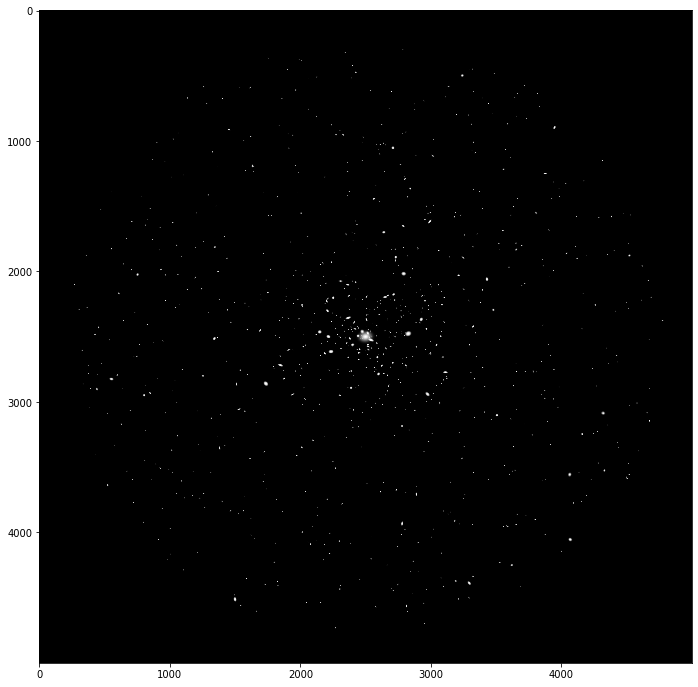

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = df.canvas.array + 0.001
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)


# Add ICL

In [8]:
galpath = "./ICL/evolving_red_gal.dat"
mstarpath = "./ICL/mstar_des_i03.fit"
jk_profile_root = "./ICL/jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"

bcg = {
    "size": 32.,
    "g1": 0.1356766444194723,
    "g2":-0.0345231539560347,
    "imag": 17.76,
    "color_gr": 1.36,
    "color_ri": 0.54,
    "color_iz": 0.32,
}
mass = 10**14.45
z = 0.3

In [10]:
di = icl.DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)

In [11]:
di.get_icl()

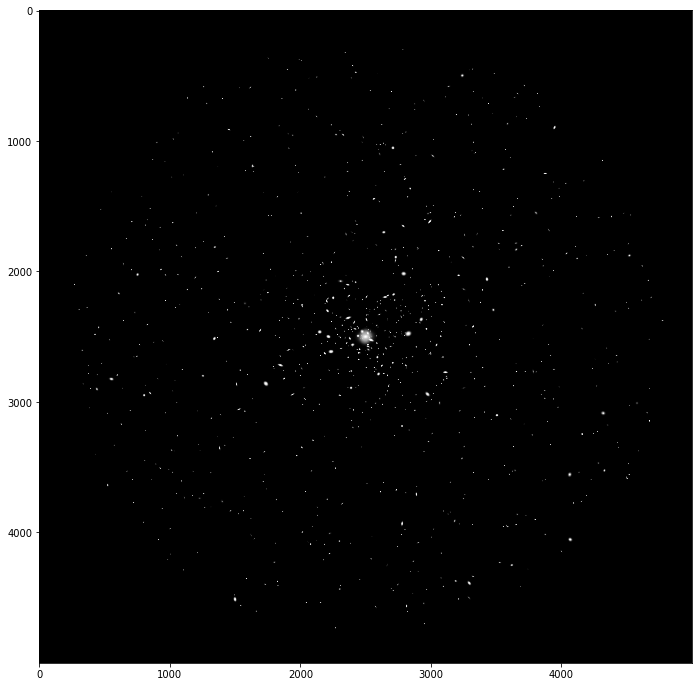

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = df.canvas.array + di.flux_z
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)

In [50]:


class DrawICL(object):
    def __init__(self, mass, z, bcg, galpath, mstarpath, jk_profile_root,
                 pixel_scale=0.264, canvas_size=5000, H0=70, Om0=0.3):
    
        self.mass = mass
        self.z = z
        self.bcg = bcg
        self.pixel_scale = pixel_scale
        self.canvas_size = canvas_size
        self.galpath = galpath
        self.mstarpath = mstarpath
        self.jk_profile_root = jk_profile_root
        self.H0 = H0
        self.Om0 = Om0
        
    def load_data(self):
        self.procmag = icl.ProcMag(self.galpath, self.mstarpath)
        self.iclprof = icl.ICLProf(self.jk_profile_root, self.procmag, H0=self.H0, Om0=self.Om0)

    def prepare_icl(self):
        
        sval = np.sqrt(bcg["size"])
        
        
        xsize = self.canvas_size
        ysize = self.canvas_size
        xcen = xsize / 2.
        ycen = ysize / 2.
        
        _xx = np.array([np.arange(xsize), ] * ysize) - xcen
        _yy = np.array([np.arange(ysize), ] * xsize).T - ycen
        xx = (1 - bcg["g1"]) * _xx - bcg["g2"] * _yy
        yy = - bcg["g2"] * _xx + (1 + bcg["g1"]) * _yy
        self.rmatrix = np.sqrt(xx**2. + yy**2.)
        
        _rvals = self.rmatrix.flatten()
        _iclarr = self.iclprof.icl_pixes(_rvals, mass=self.mass, z=self.z)
        iclarr = _iclarr * (1 - render.sigmoid(_rvals * self.pixel_scale, k=1, pos=sval))

        self.iclvals = iclarr.reshape((ysize, xsize))
        self.iclvals[iclvals < 1.] = 1.
        
    def colorize_icl(self):        
        self.magvals_i = render.tomag(iclvals)
        self.magvals_g = self.bcg["color_gr"] + self.bcg["color_ri"] + self.magvals_i
        self.magvals_r = self.bcg["color_ri"] + self.magvals_i
        self.magvals_z = self.magvals_i - self.bcg["color_iz"]

        self.flux_g = render.toflux(self.magvals_g).T
        self.flux_r = render.toflux(self.magvals_r).T
        self.flux_i = render.toflux(self.magvals_i).T
        self.flux_z = render.toflux(self.magvals_z).T

In [51]:
di = DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)

In [52]:
di.load_data()
di.prepare_icl()

In [53]:
di.colorize_icl()

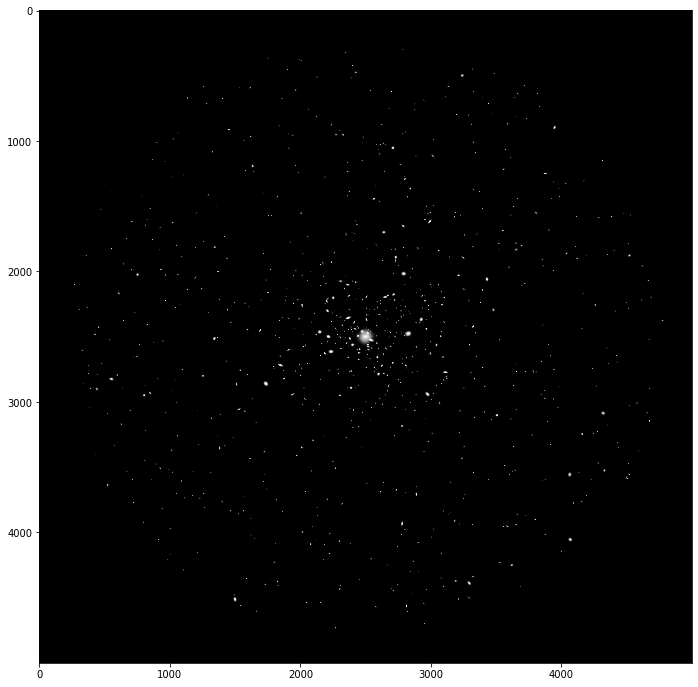

In [58]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = df.canvas.array + di.flux_z
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)

(5000, 5000)

In [25]:
xsize = 5000
ysize = 5000

# xsize = 400
# ysize = 1300

xcen = xsize / 2.
ycen = ysize / 2.

_xx = np.array([np.arange(xsize), ] * ysize) - xcen
_yy = np.array([np.arange(ysize), ] * xsize).T - ycen
xx = (1 - g1) * _xx - g2 * _yy
yy = - g2 * _xx + (1+ g1) * _yy
rmatrix = np.sqrt(xx**2. + yy**2.)

In [27]:
_rvals = rmatrix.flatten()
_iclarr = iclprof.icl_pixes(_rvals, mass=mass, z=z)
iclarr = _iclarr * (1-  render.sigmoid(_rvals*0.27, k=1, pos=sval))

iclvals = iclarr.reshape((ysize, xsize))

In [28]:
iclvals[iclvals < 1.] = 1.

In [33]:
magvals_i = render.tomag(iclvals)
magvals_g = _gr + _ri + magvals_i
magvals_r = _ri + magvals_i
magvals_z = magvals_i - _iz

flux_g = render.toflux(magvals_g).T
flux_r = render.toflux(magvals_r).T
flux_i = render.toflux(magvals_i).T

In [34]:
flux_g0 = flux_g
flux_r0 = flux_r
flux_i0 = flux_i